In [1]:
#%%appyter init
from appyter import magic
magic.init(lambda _=globals: _())

In [2]:
%%appyter hide_code
{% do SectionField(
    name='PRIMARY',
    title='Enrichr Consensus Terms',
    subtitle='This appyter returns consensus Enrichr terms using a set of gene sets',
    img='enrichr.png'
) %}

# Enrichr Consensus Terms

In [3]:
import time
import requests
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, IFrame, Markdown
import math
import scipy.stats as st
import fastcluster

In [4]:
clustergrammer_url = 'https://amp.pharm.mssm.edu/clustergrammer/matrix_upload/'
ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr'
libraries = ["ChEA_2016", "GO_Biological_Process_2018" ,"GWAS_Catalog_2019" , "KEGG_2019_Human"]
table = 1
figure = 1

In [5]:
def clustergrammer(df, name, clustergrammer_url, fignum=1, label="Clustergrammer"):
    clustergram_df = df.rename(columns={i:"Signature: %s"%i for i in df.columns}, index={i:"Enriched Term: %s"%i for i in df.index})
    clustergram_df.to_csv(name, sep="\t")
    response = ''
    for i in range(5):
        try:
            res = requests.post(clustergrammer_url, files={'file': open(name, 'rb')})
            if not res.ok:
                response = res.text
                time.sleep(1)
            else:
                clustergrammer_url = res.text.replace("http:","https:")   
                break
        except Exception as e:
            response = e
            time.sleep(2)
    else:
        if type(response) == Exception:
            raise response
        else:
            raise Exception(response)
    display(IFrame(clustergrammer_url, width="1000", height="1000"))
    display(Markdown("**Figure %d** %s [Go to url](%s)"%(fignum, label, clustergrammer_url)))

In [6]:
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=1, dark=0)
def heatmap(df, filename, width=15, height=15):
#     fig = plt.figure(figsize=(width,height))
    cg = sns.clustermap(df, cmap=cmap, figsize=(width, height), cbar_pos=(0.02, 0.65, 0.05, 0.18),)
    cg.ax_row_dendrogram.set_visible(False)
    cg.ax_col_dendrogram.set_visible(False)
    display(cg)
    plt.show()
    cg.savefig(filename)

In [7]:
# Enrichr Functions
def addList(genes, description):
    payload = {
        'list': (None, '\n'.join(genes)),
        'description': (None, description)
    }
    res = requests.post(ENRICHR_URL + "/addList", files=payload)
    if not res.ok:
        raise Exception('Error analyzing gene list')
    data = res.json()
    return data["userListId"]

def enrich(userListId, library, alpha):
    res = requests.get(
        ENRICHR_URL +"/enrich", params={"userListId": userListId, "backgroundType": library}
     )
    if not res.ok:
        raise Exception('Error fetching enrichment results')
    data = res.json()
    return [i for i in data[library] if i[2] < alpha]

## Get Input

In [8]:
%%appyter code_exec


{% set input_gene_set = FileField(
    name='input_gene_set',
    label='Gene Set',
    default='input.gmt',
    section="PRIMARY",
    examples={
        'example.gmt': 'https://appyters.maayanlab.cloud/storage/EnrichrConsensus/sample_input/input.gmt'
    }
) %}

input_gene_set = {{ input_gene_set }}

```python

input_gene_set = 'input.gmt'
```

In [9]:
enrichment = {}
with open(input_gene_set) as o:
    for line in o:
        unpacked = line.strip().split("\t\t")
        if not len(unpacked) == 2:
            raise ValueError("GMT is not formatted properly, please consult the README of the appyter for proper formatting")
        sigid, geneset_str = unpacked
        geneset = geneset_str.split("\t")
        enrichment[sigid] = {
            "genes": [i.split(",")[0] for i in geneset]
        }

In [10]:
input_sigs = pd.DataFrame.from_dict(enrichment, orient="index")
display(input_sigs.head(10))
display(Markdown("**Table %d** Input Signatures"%(table)))
table+=1

,genes
Diabetic Neuropathy GSE11343,"[TMEM170A, PCGF6, ANKFY1, CNBP, PLEKHA1, RPL23..."
Erectile dysfunction assoc with type 2 diabetes GSE2457 186,"[ACTN3, CNBP, UBAC1, COL1A2, COL1A1, CCDC80, S..."
Kidney disorder assoc with type 2 diabetes GSE2557 8,"[2410006H16RIK, NGDN, RPL23, AMFR, MRPS18B, WD..."
Type 1 diabetes mellitus GSE10586,"[SRRM3, B3GALNT1, ZNF705G, ENTPD3, BTBD16, ESX..."
Type 1 diabetes mellitus GSE10586 9,"[C9ORF135, IL1R1, PLEKHA2, LRRC37A2, EPR1, SCA..."
Type 1 diabetes mellitus GSE11,"[SS18L1, PEX19, LOC441052, HOMER3, AP1S1, TAAR..."
Type 1 diabetes mellitus GSE11 173,"[CDK18, 1810058I24RIK, AW112010, RPL21, MX2, S..."
Type 1 diabetes mellitus GSE11 178,"[1810058I24RIK, ACTN1, KRT8, PPP2R1A, NUP210, ..."
Type 1 diabetes mellitus GSE1623 53,"[SSB, LUM, IFRD1, WDR83OS, DEK, SMARCA2, HSPE1..."
Type 1 diabetes mellitus GSE1659 346,"[ENTPD4, GDAP1, UBAC1, COL1A1, MYL1, SDPR, FDX..."


**Table 1** Input Signatures

## User defined parameters

In [11]:
%%appyter code_exec
alpha = {{FloatField(name='alpha', label='p-value cutoff', default=0.05, section='PRIMARY')}}
top_results = {{IntField(name='min_count', label='Top results', description="Number of top results to keep", default=50, section='PRIMARY')}}
width = {{FloatField(name='width', label='image width', default=15, section='PRIMARY')}}
height = {{FloatField(name='height', label='image height', default=15, section='PRIMARY')}}

```python
alpha = 0.05
top_results = 50
width = 15.0
height = 15.0
```

## Enrichment

In [12]:
failed_userlist = []
failed_enrich = {}
store = None
lib = "GWAS_Catalog_2019"
sig = "Type 1 diabetes mellitus GSE11 173"
for description, values in enrichment.items():
    print("Querying %s"%(description), end="\r", flush=True)
    genes = values["genes"]
    for tries in range(5):
        try:
            userListId = addList(genes, description)
            enrichment[description]["userListId"] = userListId
            break
        except Exception as e:
            print(e)
            time.sleep(0.5)
    else:
        failed_userlist.append(description)
        continue
    time.sleep(0.1)
    enrichment[description]["libraries"] = {}

    for library in libraries:
        for tries in range(5):
            try:
                userlistId = enrichment[description]["userListId"]
                results = enrich(userListId, library, alpha)
                if description == sig and library == lib:
                    store = results
                enrichment[description]["libraries"][library] = results
                break
            except Exception as e:
                print(e)
                time.sleep(0.5)
        else:
            if description not in failed_enrich:
                failed_enrich[description] = []
            failed_enrich[description].append(library)
            continue
        time.sleep(0.1)
if len(failed_userlist):
    print("Failed to add %d list"%len(failed_userlist))
if len(failed_enrich):
    print("Failed enrichment for %d gene sets"%len(failed_enrich))

In [13]:
input_enrichment_df = {}
num_sigs = len(enrichment)
for lib in libraries:
    term_df = pd.DataFrame(index=enrichment.keys())
    for k,v in enrichment.items():
        sigs = v["libraries"][lib]
        for sig in sigs:
            term = sig[1]
            if term not in term_df.columns:
                term_df[term] = 0.0
            p = sig[2]
            term_df.at[k, term] = -math.log(p)
    term_df = term_df.transpose()
#     term_df = term_df[term_df.sum(1)>=min_count]
    term_df.to_csv("%s_enrichment.tsv"%lib, sep="\t")
    input_enrichment_df[lib] = term_df
    display(term_df.head(10))
    display(Markdown("**Table %d** The table below shows the result of the enrichment analysis of %d gene sets \
        with the %s library in Enrichr. Each score is computed by getting the negative logarithm of the p-value \
        ($-\ln{pval}$). [Download complete table](%s_enrichment.tsv)"%(table, num_sigs, lib.replace("_"," "), lib)))
    table+=1

,Diabetic Neuropathy GSE11343,Type 1 diabetes mellitus GSE10586,Type 1 diabetes mellitus GSE11,Type 1 diabetes mellitus GSE10586 9,Type 2 diabetes mellitus GSE12643 274,Type 2 diabetes mellitus GSE2899 299,Type 2 diabetes mellitus GSE2899 279,type 2 diabetes mellitus GSE54917 614,type 1 diabetes mellitus GSE4990 474,Type 2 diabetes mellitus GSE2899 45,...,Type 2 diabetes mellitus GSE2899 203,Type 2 diabetes mellitus GSE3068 335,Type 2 diabetes mellitus GSE642 320,Type 1 diabetes mellitus GSE1659 346,type 2 diabetes mellitus GSE23343 895,Type 2 diabetes mellitus GSE6428 291,type 2 diabetes mellitus GSE13760 882,Type 1 diabetes mellitus GSE4616 363,Type 1 diabetes mellitus GSE1623 53,Type 1 diabetes mellitus GSE11 173
KDM5B 21448134 ChIP-Seq MESCs Mouse,31.888180,0.0,0.0,0.0,5.651933,0.000000,0.000000,0.0,10.300980,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,22.046403,6.385816,0.000000,19.858792,0.000000
CREM 20920259 ChIP-Seq GC1-SPG Mouse,23.955371,0.0,0.0,0.0,5.035774,0.000000,0.000000,0.0,20.614095,0.0,...,0.000000,12.535176,0.000000,6.223299,0.0,44.061922,17.767232,12.527369,8.536751,0.000000
ETS1 20019798 ChIP-Seq JURKAT Human,18.948770,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,7.860894,8.370002,0.000000,0.0,11.427219,0.000000,4.038202,6.680730,0.000000
VDR 23849224 ChIP-Seq CD4+ Human,17.811524,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,9.223498,0.0,...,3.315563,6.581259,7.745413,6.107936,0.0,6.408093,3.640852,7.647336,5.291673,0.000000
FOXO3 22982991 ChIP-Seq MACROPHAGES Mouse,16.726140,0.0,0.0,0.0,0.000000,3.470107,0.000000,0.0,6.621784,0.0,...,0.000000,9.069128,3.834901,4.731948,0.0,5.680738,0.000000,3.713111,3.628054,0.000000
MYC 19030024 ChIP-ChIP MESCs Mouse,14.026499,0.0,0.0,0.0,6.080148,4.776192,0.000000,0.0,36.679969,0.0,...,6.898253,13.836221,18.597050,10.045095,0.0,51.574744,3.076022,27.739231,29.056818,0.000000
E2F1 18555785 ChIP-Seq MESCs Mouse,12.525521,0.0,0.0,0.0,3.240986,0.000000,0.000000,0.0,38.441522,0.0,...,0.000000,21.058328,19.629016,17.346561,0.0,30.358822,13.329871,27.357628,18.500443,0.000000
XRN2 22483619 ChIP-Seq HELA Human,12.301836,0.0,0.0,0.0,0.000000,10.683477,3.931814,0.0,29.290412,0.0,...,0.000000,8.883330,19.974446,8.058252,0.0,40.904237,9.061946,14.186790,8.357440,0.000000
FOXP3 21729870 ChIP-Seq TREG Human,11.984269,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,5.147753,0.000000,4.165462,0.0,0.000000,0.000000,3.195815,0.000000,0.000000
TAL1 20887958 ChIP-Seq HPC-7 Mouse,11.650895,0.0,0.0,0.0,0.000000,6.033079,0.000000,0.0,52.370360,0.0,...,4.916755,13.272933,11.766134,4.736824,0.0,34.494638,4.616818,22.183646,8.088308,7.239667


**Table 2** The table below shows the result of the enrichment analysis of 26 gene sets         with the ChEA 2016 library in Enrichr. Each score is computed by getting the negative logarithm of the p-value         ($-\ln{pval}$). [Download complete table](ChEA_2016_enrichment.tsv)

,Diabetic Neuropathy GSE11343,Type 1 diabetes mellitus GSE10586,Type 1 diabetes mellitus GSE11,Type 1 diabetes mellitus GSE10586 9,Type 2 diabetes mellitus GSE12643 274,Type 2 diabetes mellitus GSE2899 299,Type 2 diabetes mellitus GSE2899 279,type 2 diabetes mellitus GSE54917 614,type 1 diabetes mellitus GSE4990 474,Type 2 diabetes mellitus GSE2899 45,...,Type 2 diabetes mellitus GSE2899 203,Type 2 diabetes mellitus GSE3068 335,Type 2 diabetes mellitus GSE642 320,Type 1 diabetes mellitus GSE1659 346,type 2 diabetes mellitus GSE23343 895,Type 2 diabetes mellitus GSE6428 291,type 2 diabetes mellitus GSE13760 882,Type 1 diabetes mellitus GSE4616 363,Type 1 diabetes mellitus GSE1623 53,Type 1 diabetes mellitus GSE11 173
cellular protein metabolic process (GO:0044267),16.239679,0.0,0.000000,0.0,0.000000,28.804773,6.538648,0.0,13.377691,5.125931,...,0.0,3.815601,29.614529,0.0,0.0,46.945377,0.000000,14.966616,5.454772,0.000000
protein targeting to ER (GO:0045047),15.293548,0.0,4.170451,0.0,0.000000,39.501497,4.067948,0.0,24.189037,0.000000,...,0.0,0.000000,47.211865,0.0,0.0,39.548847,0.000000,8.236419,0.000000,3.908543
nuclear-transcribed mRNA catabolic process (GO:0000956),14.748956,0.0,4.122065,0.0,0.000000,33.265543,0.000000,0.0,25.077659,0.000000,...,0.0,0.000000,43.411636,0.0,0.0,27.349417,3.018433,7.047028,0.000000,4.934194
SRP-dependent cotranslational protein targeting to membrane (GO:0006614),13.935049,0.0,4.514546,0.0,0.000000,41.233695,4.409537,0.0,28.108170,0.000000,...,0.0,0.000000,52.593299,0.0,0.0,35.617170,0.000000,8.834102,0.000000,4.246070
"nuclear-transcribed mRNA catabolic process, nonsense-mediated decay (GO:0000184)",13.829448,0.0,4.979145,0.0,0.000000,39.595927,4.855628,0.0,24.236724,0.000000,...,0.0,0.000000,52.657543,0.0,0.0,31.141848,0.000000,8.911824,0.000000,3.366388
cotranslational protein targeting to membrane (GO:0006613),13.524802,0.0,4.337700,0.0,0.000000,40.345747,4.233947,0.0,24.854915,0.000000,...,0.0,0.000000,51.430818,0.0,0.0,37.581543,0.000000,8.527270,0.000000,4.072515
peptide biosynthetic process (GO:0043043),12.955885,0.0,3.043444,0.0,0.000000,33.265543,0.000000,0.0,17.326357,0.000000,...,0.0,0.000000,40.863273,0.0,0.0,25.195514,0.000000,14.887560,0.000000,0.000000
viral process (GO:0016032),11.965985,0.0,3.023277,0.0,0.000000,37.971576,3.861294,0.0,24.349286,0.000000,...,0.0,0.000000,34.963859,0.0,0.0,28.832805,0.000000,10.466435,3.815362,7.019643
negative regulation of translation (GO:0017148),11.883360,0.0,0.000000,0.0,3.655916,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,7.348401,0.000000,0.000000,0.000000,0.000000
translation (GO:0006412),11.360612,0.0,0.000000,0.0,0.000000,27.526563,0.000000,0.0,17.990209,0.000000,...,0.0,3.990759,33.664255,0.0,0.0,33.919342,0.000000,12.801724,0.000000,0.000000


**Table 3** The table below shows the result of the enrichment analysis of 26 gene sets         with the GO Biological Process 2018 library in Enrichr. Each score is computed by getting the negative logarithm of the p-value         ($-\ln{pval}$). [Download complete table](GO_Biological_Process_2018_enrichment.tsv)

,Diabetic Neuropathy GSE11343,Type 1 diabetes mellitus GSE10586,Type 1 diabetes mellitus GSE11,Type 1 diabetes mellitus GSE10586 9,Type 2 diabetes mellitus GSE12643 274,Type 2 diabetes mellitus GSE2899 299,Type 2 diabetes mellitus GSE2899 279,type 2 diabetes mellitus GSE54917 614,type 1 diabetes mellitus GSE4990 474,Type 2 diabetes mellitus GSE2899 45,...,Type 2 diabetes mellitus GSE2899 203,Type 2 diabetes mellitus GSE3068 335,Type 2 diabetes mellitus GSE642 320,Type 1 diabetes mellitus GSE1659 346,type 2 diabetes mellitus GSE23343 895,Type 2 diabetes mellitus GSE6428 291,type 2 diabetes mellitus GSE13760 882,Type 1 diabetes mellitus GSE4616 363,Type 1 diabetes mellitus GSE1623 53,Type 1 diabetes mellitus GSE11 173
"Functional impairment in major depressive disorder, bipolar disorder and schizophrenia",5.130228,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Bipolar disorder or major depressive disorder,4.888823,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Polymyositis,4.312342,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Glaucoma (primary angle closure),4.312342,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Periodontitis (Mean PAL),4.176915,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Primary biliary cholangitis,3.616139,0.000000,0.0,14.911676,0.000000,3.015423,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.366388
Atrial fibrillation,3.545535,0.000000,0.0,0.000000,4.433426,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Extremely high intelligence,3.513570,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Rhegmatogenous retinal detachment,3.429092,0.000000,0.0,0.000000,0.000000,0.000000,5.836586,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Frontotemporal dementia with GRN mutation (age at onset),0.000000,9.646887,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


**Table 4** The table below shows the result of the enrichment analysis of 26 gene sets         with the GWAS Catalog 2019 library in Enrichr. Each score is computed by getting the negative logarithm of the p-value         ($-\ln{pval}$). [Download complete table](GWAS_Catalog_2019_enrichment.tsv)

,Diabetic Neuropathy GSE11343,Type 1 diabetes mellitus GSE10586,Type 1 diabetes mellitus GSE11,Type 1 diabetes mellitus GSE10586 9,Type 2 diabetes mellitus GSE12643 274,Type 2 diabetes mellitus GSE2899 299,Type 2 diabetes mellitus GSE2899 279,type 2 diabetes mellitus GSE54917 614,type 1 diabetes mellitus GSE4990 474,Type 2 diabetes mellitus GSE2899 45,...,Type 2 diabetes mellitus GSE2899 203,Type 2 diabetes mellitus GSE3068 335,Type 2 diabetes mellitus GSE642 320,Type 1 diabetes mellitus GSE1659 346,type 2 diabetes mellitus GSE23343 895,Type 2 diabetes mellitus GSE6428 291,type 2 diabetes mellitus GSE13760 882,Type 1 diabetes mellitus GSE4616 363,Type 1 diabetes mellitus GSE1623 53,Type 1 diabetes mellitus GSE11 173
Ribosome,9.134880,0.0,3.572795,0.0,0.000000,33.293876,3.462353,0.000000,21.262623,0.0,...,0.0,0.000000,38.951922,0.0,0.0,23.194620,0.000000,11.208439,0.000000,0.000000
Spliceosome,8.550504,0.0,0.000000,0.0,6.412686,0.000000,0.000000,0.000000,5.601489,0.0,...,0.0,0.000000,5.379740,0.0,0.0,0.000000,4.253660,4.775330,8.501817,0.000000
RNA transport,8.514811,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,12.468435,3.255981,0.000000,0.000000,0.000000
Lysosome,5.962423,0.0,0.000000,0.0,0.000000,0.000000,16.673133,3.222229,37.080637,0.0,...,0.0,0.000000,5.852490,0.0,0.0,0.000000,0.000000,0.000000,0.000000,5.589387
Glycosaminoglycan degradation,5.911000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
Protein processing in endoplasmic reticulum,5.648687,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,24.025529,0.0,...,0.0,0.000000,6.888578,0.0,0.0,24.031736,9.465989,6.105635,8.231006,0.000000
Ubiquinone and other terpenoid-quinone biosynthesis,4.484791,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
Human papillomavirus infection,4.467636,0.0,0.000000,0.0,0.000000,0.000000,3.426489,0.000000,0.000000,0.0,...,0.0,5.848671,0.000000,0.0,0.0,0.000000,6.366775,4.423417,3.105223,0.000000
mRNA surveillance pathway,4.424869,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
Autophagy,4.357491,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,3.310582,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


**Table 5** The table below shows the result of the enrichment analysis of 26 gene sets         with the KEGG 2019 Human library in Enrichr. Each score is computed by getting the negative logarithm of the p-value         ($-\ln{pval}$). [Download complete table](KEGG_2019_Human_enrichment.tsv)

## ChEA 2016

In [14]:
lib = "ChEA_2016"

df = input_enrichment_df[lib]

consensus = df.sum(1).sort_values(ascending=False)[0:top_results].to_frame(name="scores")

# Save to tsv
consensus.to_csv("consensus_%s.tsv", sep="\t")
display(consensus.head(10))
display(Markdown("**Table %d** %s Consensus terms. \
        Consensus scores are computed by taking the sum of scores in Table 2. \
        [Download top %d terms](%s_consensus.tsv)"%(table, lib.replace("_"," "), top_results, lib)))
table+=1

,scores
EKLF 21900194 ChIP-Seq ERYTHROCYTE Mouse,380.088684
MYC 19030024 ChIP-ChIP MESCs Mouse,294.921618
NELFA 20434984 ChIP-Seq ESCs Mouse,281.205332
E2F1 18555785 ChIP-Seq MESCs Mouse,251.583291
CLOCK 20551151 ChIP-Seq 293T Human,249.296177
ESRRB 18555785 ChIP-Seq MESCs Mouse,239.746675
XRN2 22483619 ChIP-Seq HELA Human,218.113939
TAL1 20887958 ChIP-Seq HPC-7 Mouse,215.931812
TTF2 22483619 ChIP-Seq HELA Human,193.286943
CREM 20920259 ChIP-Seq GC1-SPG Mouse,190.845413


**Table 6** ChEA 2016 Consensus terms.         Consensus scores are computed by taking the sum of scores in Table 2.         [Download top 50 terms](ChEA_2016_consensus.tsv)

In [15]:
# Visualize
consensus_df = df.loc[consensus.index]
if (consensus_df.shape[1] > 0):
    clustergrammer(consensus_df, "%s_consensus_clust.tsv"%lib, clustergrammer_url, figure, 
                   "Clustergrammer for the top %d consensus terms for %s "%(top_results, lib.replace("_"," ")))
    figure+=1
else:
    print("No terms found")

**Figure 1** Clustergrammer for the top 50 consensus terms for ChEA 2016  [Go to url](https://amp.pharm.mssm.edu/clustergrammer/viz/5f45c1e1b67f786c4becfe5c/ChEA_2016_consensus_clust.tsv)

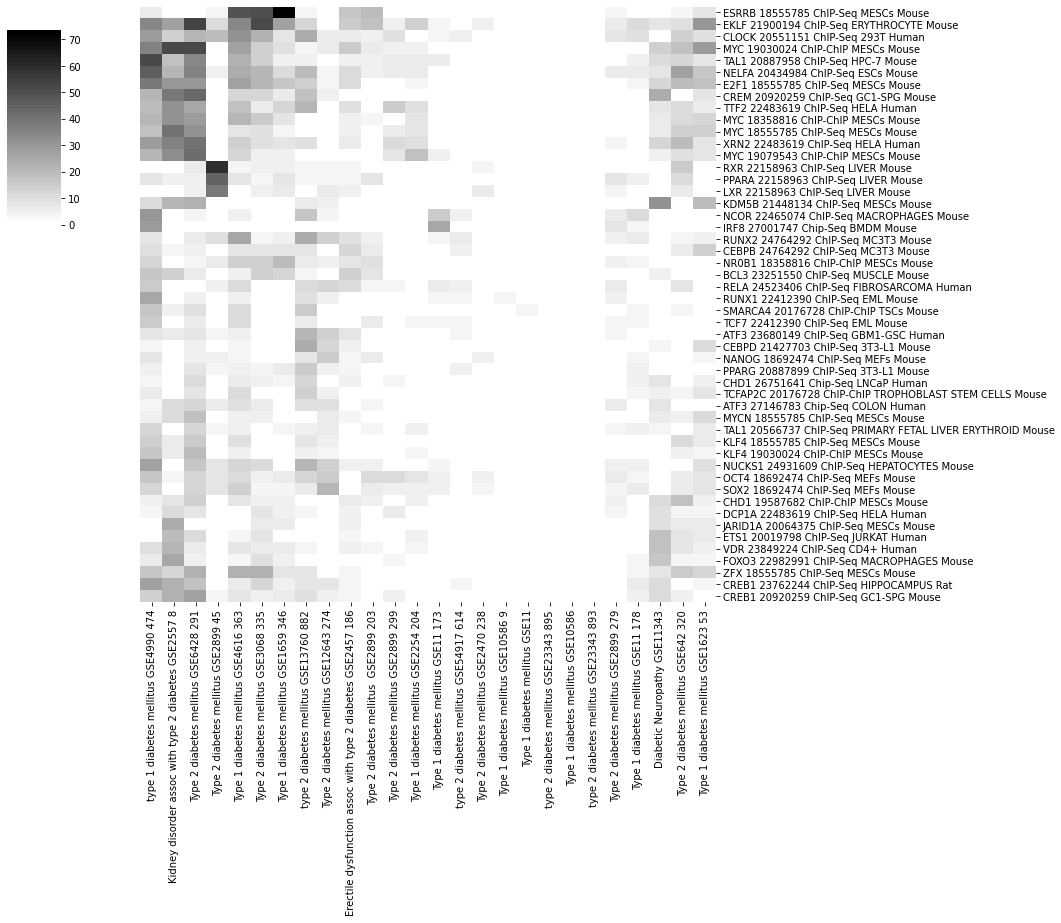

**Figure 2** Heatmap for the top 50 consensus terms for ChEA 2016. [Download figure](ChEA_2016_consensus.svg)

In [16]:
if (consensus_df.shape[1] > 0):
    heatmap(consensus_df, "%s_consensus.svg"%lib, width, height)
    display(Markdown("**Figure %d** Heatmap for the top %d consensus terms for %s. [Download figure](%s_consensus.svg)"%(figure, top_results, lib.replace("_"," "), lib)))
    figure+=1
else:
    print("No terms found")

## GO Biological Process 2018

In [17]:
lib = "GO_Biological_Process_2018"

df = input_enrichment_df[lib]

consensus = df.sum(1).sort_values(ascending=False)[0:top_results].to_frame(name="scores")

# Save to tsv
consensus.to_csv("consensus_%s.tsv", sep="\t")
display(consensus.head(10))
display(Markdown("**Table %d** %s Consensus terms. \
        Consensus scores are computed by taking the sum of scores in Table 3. \
        [Download top %d terms](%s_consensus.tsv)"%(table, lib.replace("_"," "), top_results, lib)))
table+=1

,scores
mitochondrial ATP synthesis coupled electron transport (GO:0042775),474.358984
respiratory electron transport chain (GO:0022904),463.819024
protein targeting to ER (GO:0045047),330.257319
SRP-dependent cotranslational protein targeting to membrane (GO:0006614),328.932951
cotranslational protein targeting to membrane (GO:0006613),328.729930
"mitochondrial electron transport, NADH to ubiquinone (GO:0006120)",307.124975
"nuclear-transcribed mRNA catabolic process, nonsense-mediated decay (GO:0000184)",305.410921
viral gene expression (GO:0019080),282.508094
viral transcription (GO:0019083),281.184080
cellular protein metabolic process (GO:0044267),274.144229


**Table 7** GO Biological Process 2018 Consensus terms.         Consensus scores are computed by taking the sum of scores in Table 3.         [Download top 50 terms](GO_Biological_Process_2018_consensus.tsv)

In [18]:
# Visualize
consensus_df = df.loc[consensus.index]
if (consensus_df.shape[1] > 0):
    clustergrammer(consensus_df, "%s_consensus_clust.tsv"%lib, clustergrammer_url, figure, 
                   "Clustergrammer for the top %d consensus terms for %s "%(top_results, lib.replace("_"," ")))
    figure+=1
else:
    print("No terms found")

**Figure 3** Clustergrammer for the top 50 consensus terms for GO Biological Process 2018  [Go to url](https://amp.pharm.mssm.edu/clustergrammer/viz/5f45c1ebb67f786c4becfe61/GO_Biological_Process_2018_consensus_clust.tsv)

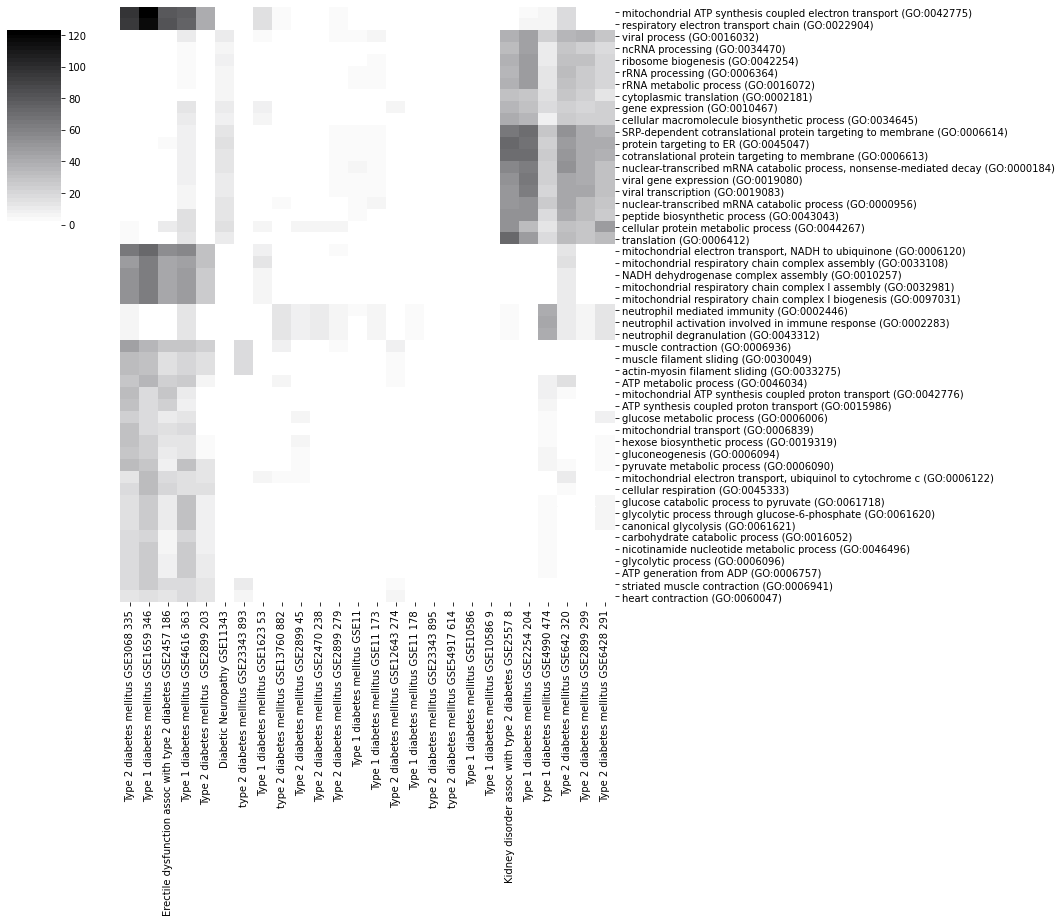

**Figure 4** Heatmap for the top 50 consensus terms for GO Biological Process 2018. [Download figure](GO_Biological_Process_2018_consensus.svg)

In [19]:
if (consensus_df.shape[1] > 0):
    heatmap(consensus_df, "%s_consensus.svg"%lib, width, height)
    display(Markdown("**Figure %d** Heatmap for the top %d consensus terms for %s. [Download figure](%s_consensus.svg)"%(figure, top_results, lib.replace("_"," "), lib)))
    figure+=1
else:
    print("No terms found")

## GWAS Catalog 2019

In [20]:
lib = "GWAS_Catalog_2019"

df = input_enrichment_df[lib]

consensus = df.sum(1).sort_values(ascending=False)[0:top_results].to_frame(name="scores")

# Save to tsv
consensus.to_csv("consensus_%s.tsv", sep="\t")
display(consensus.head(10))
display(Markdown("**Table %d** %s Consensus terms. \
        Consensus scores are computed by taking the sum of scores in Table 4. \
        [Download top %d terms](%s_consensus.tsv)"%(table, lib.replace("_"," "), top_results, lib)))
table+=1

,scores
Primary biliary cholangitis,28.026987
Inflammatory bowel disease,22.733280
LDL cholesterol levels,18.414497
Homeostasis model assessment of beta-cell function,17.093594
Systolic blood pressure x smoking status (current vs non-current) interaction (2df test),16.644937
Celiac disease,16.565802
Fasting blood glucose (BMI interaction),16.507232
Systemic sclerosis,16.313665
Glomerular filtration rate (creatinine),15.800563
Diastolic blood pressure x smoking status (current vs non-current) interaction (2df test),15.420724


**Table 8** GWAS Catalog 2019 Consensus terms.         Consensus scores are computed by taking the sum of scores in Table 4.         [Download top 50 terms](GWAS_Catalog_2019_consensus.tsv)

In [21]:
# Visualize
consensus_df = df.loc[consensus.index]
if (consensus_df.shape[1] > 0):
    clustergrammer(consensus_df, "%s_consensus_clust.tsv"%lib, clustergrammer_url, figure, 
                   "Clustergrammer for the top %d consensus terms for %s "%(top_results, lib.replace("_"," ")))
    figure+=1
else:
    print("No terms found")

**Figure 5** Clustergrammer for the top 50 consensus terms for GWAS Catalog 2019  [Go to url](https://amp.pharm.mssm.edu/clustergrammer/viz/5f45c1f3b67f786c4becfe66/GWAS_Catalog_2019_consensus_clust.tsv)

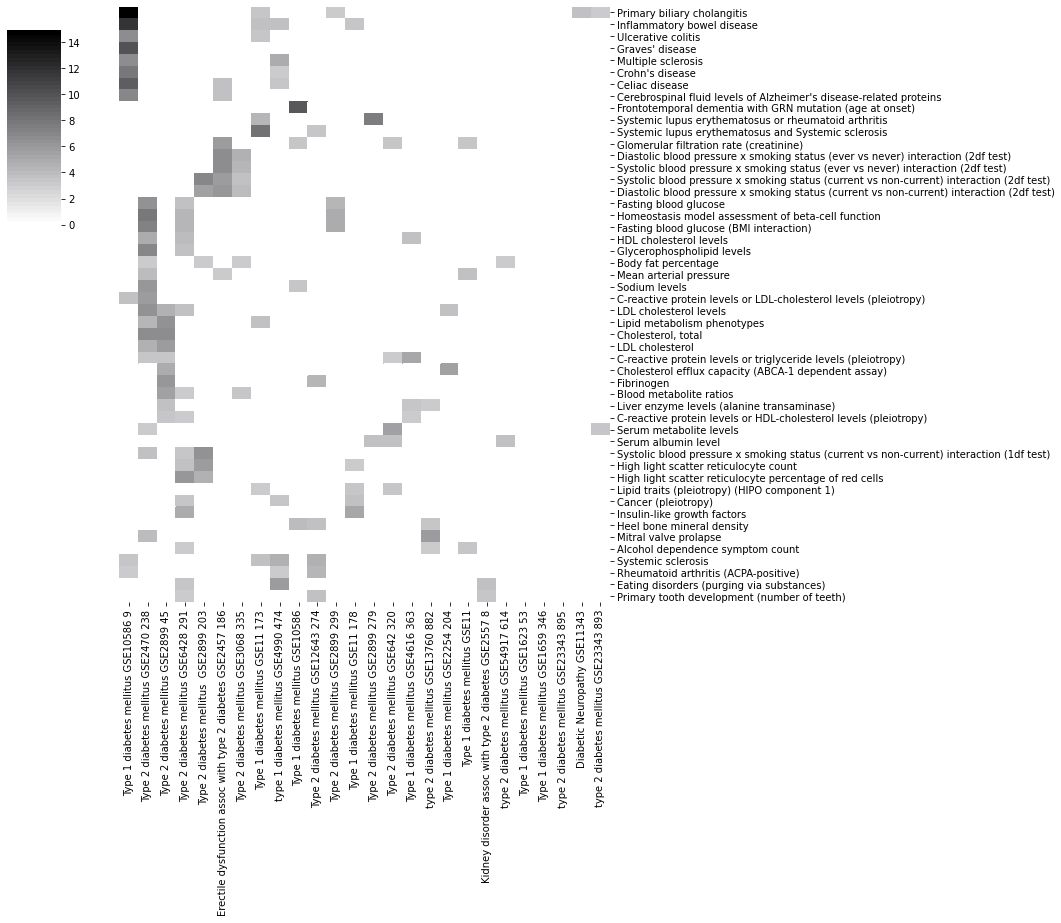

**Figure 6** Heatmap for the top 50 consensus terms for GWAS Catalog 2019. [Download figure](GWAS_Catalog_2019_consensus.svg)

In [22]:
if (consensus_df.shape[1] > 0):
    heatmap(consensus_df, "%s_consensus.svg"%lib, width, height)
    display(Markdown("**Figure %d** Heatmap for the top %d consensus terms for %s. [Download figure](%s_consensus.svg)"%(figure, top_results, lib.replace("_"," "), lib)))
    figure+=1
else:
    print("No terms found")

## KEGG 2019 Human

In [23]:
lib = "KEGG_2019_Human"

df = input_enrichment_df[lib]

consensus = df.sum(1).sort_values(ascending=False)[0:top_results].to_frame(name="scores")

# Save to tsv
consensus.to_csv("consensus_%s.tsv", sep="\t")
display(consensus.head(10))
display(Markdown("**Table %d** %s Consensus terms. \
        Consensus scores are computed by taking the sum of scores in Table 5. \
        [Download top %d terms](%s_consensus.tsv)"%(table, lib.replace("_"," "), top_results, lib)))
table+=1

,scores
Parkinson disease,481.959504
Oxidative phosphorylation,449.096861
Non-alcoholic fatty liver disease (NAFLD),441.582727
Alzheimer disease,431.706009
Huntington disease,388.580155
Thermogenesis,370.687330
Ribosome,257.276589
Retrograde endocannabinoid signaling,210.545975
Cardiac muscle contraction,206.970187
Protein processing in endoplasmic reticulum,163.671846


**Table 9** KEGG 2019 Human Consensus terms.         Consensus scores are computed by taking the sum of scores in Table 5.         [Download top 50 terms](KEGG_2019_Human_consensus.tsv)

In [24]:
# Visualize
consensus_df = df.loc[consensus.index]
if (consensus_df.shape[1] > 0):
    clustergrammer(consensus_df, "%s_consensus_clust.tsv"%lib, clustergrammer_url, figure, 
                   "Clustergrammer for the top %d consensus terms for %s "%(top_results, lib.replace("_"," ")))
    figure+=1
else:
    print("No terms found")

**Figure 7** Clustergrammer for the top 50 consensus terms for KEGG 2019 Human  [Go to url](https://amp.pharm.mssm.edu/clustergrammer/viz/5f45c1fbb67f786c4becfe6b/KEGG_2019_Human_consensus_clust.tsv)

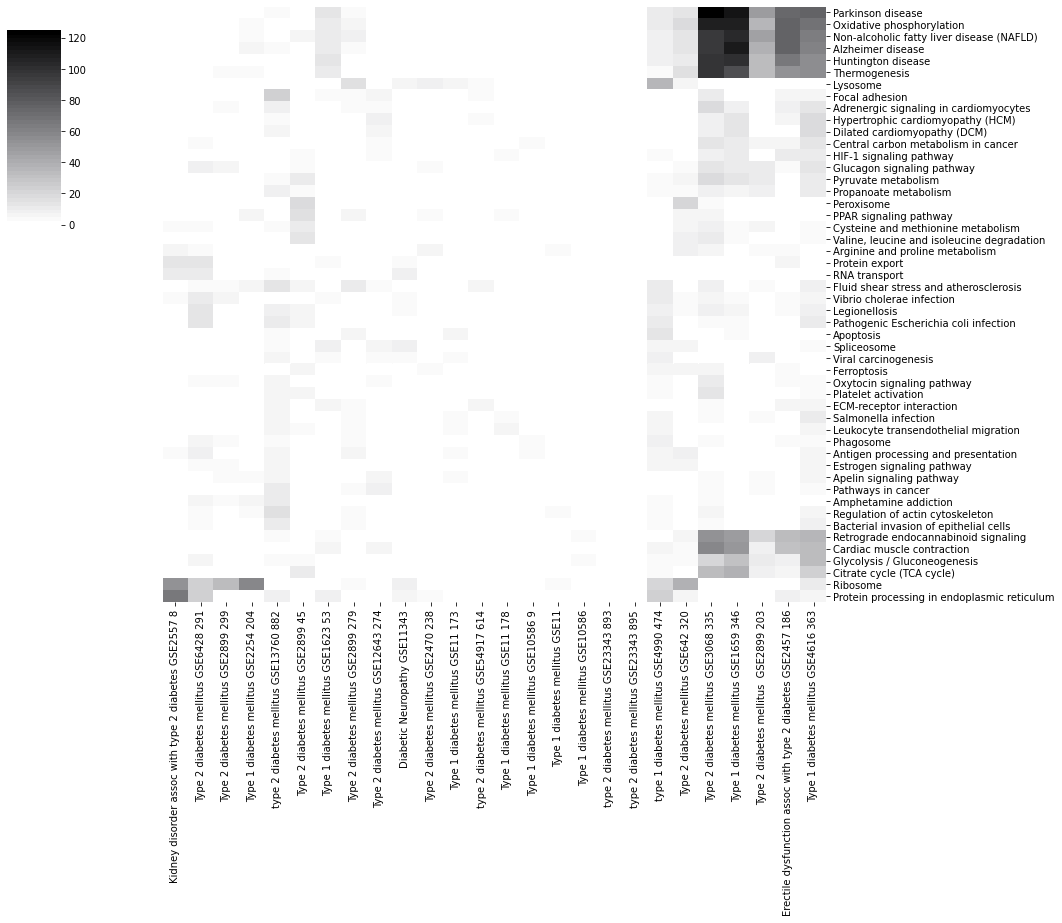

**Figure 8** Heatmap for the top 50 consensus terms for KEGG 2019 Human. [Download figure](KEGG_2019_Human_consensus.svg)

In [25]:
if (consensus_df.shape[1] > 0):
    heatmap(consensus_df, "%s_consensus.svg"%lib, width, height)
    display(Markdown("**Figure %d** Heatmap for the top %d consensus terms for %s. [Download figure](%s_consensus.svg)"%(figure, top_results, lib.replace("_"," "), lib)))
    figure+=1
else:
    print("No terms found")